In [269]:
# https://www.kaggle.com/xhlulu/vgg-16-on-cifar10-with-keras-beginner

import os
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [270]:
def unpickle(file, encoding='bytes'):
    with open(file, 'rb') as f:
        di = pickle.load(f, encoding=encoding)
    return di

# return the index of label
def onehot_to_label(vector):
    # vector: [0,0,0,0,0,0,1,0,0,0]
    for i in range(len(vector)):
        if vector[i] == 1:
            return i

## Loading Data

Dataset: https://www.cs.toronto.edu/~kriz/cifar.html

### Load the label names

In [271]:
batches_meta = unpickle(f"cifar-10-batches-py/batches.meta", encoding='utf-8')
label_names = batches_meta['label_names']

### Load Training Data

In [272]:
batch_labels = []
batch_images = []

for n in range(1, 6):
    batch_dict = unpickle(f"cifar-10-batches-py/data_batch_{n}")
    # Add labels to the list of batch labels
    batch_labels.append(batch_dict[b'labels'])
    
    # Load the images, and resize them to 10000x3x32x32
    data = batch_dict[b'data'].reshape((10000,3,32,32))
    # Modify axis to be 10000x32x32x3, since this is the correct order for keras
    data = np.moveaxis(data, 1, -1)
    batch_images.append(data)

labels = np.concatenate(batch_labels, axis=0)
images = np.concatenate(batch_images, axis=0)

### Load Test Data

In [273]:
test_dict = unpickle(f"cifar-10-batches-py/test_batch")
test_labels = np.array(test_dict[b'labels'])
test_images = test_dict[b'data'].reshape((10000,3,32,32))
test_images = np.moveaxis(test_images, 1, -1)

### Viewing the datasets

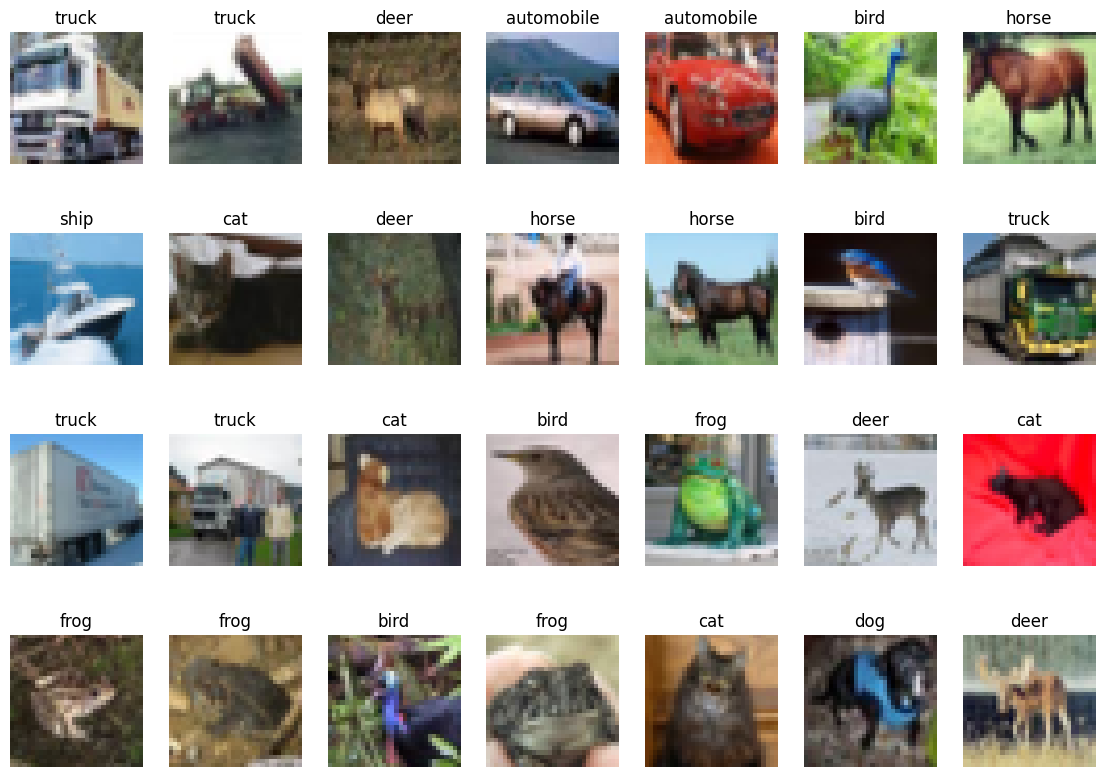

In [274]:
fig = plt.figure(figsize=(14,10))

for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = images[n]
    plt.imshow(img)
    plt.title(label_names[labels[n]])
    plt.axis('off')

## Preprocessing

In [275]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical

# We normalize the input according to the methods used in the paper
X_train = preprocess_input(images)
y_test = to_categorical(test_labels)

# We one-hot-encode the labels for training
X_test = preprocess_input(test_images)
y_train = to_categorical(labels)

## Load and Compile the Model

In [276]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(
    weights=None, 
    include_top=True, 
    classes=10,
    input_shape=(32,32,3)
)

# Expand this cell for the model summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

The model specifications are given on page 4 of the original paper: https://arxiv.org/pdf/1409.1556.pdf

> The ConvNet training procedure generally follows Krizhevsky et al. (2012) (except for sampling
the input crops from multi-scale training images, as explained later). Namely, the training is carried
out by optimising the multinomial logistic regression objective using mini-batch gradient descent
(based on back-propagation (LeCun et al., 1989)) with momentum. The batch size was set to 256,
momentum to 0.9. The training was regularised by weight decay (the $L_2$ penalty multiplier set to
$5 \cdot 10^{−4}$
) and dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5).
The learning rate was initially set to $10^{−2}$
, and then decreased by a factor of 10 when the validation
set accuracy stopped improving. In total, the learning rate was decreased 3 times, and the learning
was stopped after 370K iterations (74 epochs). We conjecture that in spite of the larger number of
parameters and the greater depth of our nets compared to (Krizhevsky et al., 2012), the nets required
less epochs to converge due to (a) implicit regularisation imposed by greater depth and smaller conv.
filter sizes; (b) pre-initialisation of certain layers.

In [277]:
from tensorflow.keras import optimizers

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

## Training the model

In [278]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint(
#     'model.h5', 
#     monitor='val_acc', 
#     verbose=0, 
#     save_best_only=True, 
#     save_weights_only=False,
#     mode='auto'
# )

# # Train the model
# history = model.fit(
#     x=X_train,
#     y=y_train,
#     validation_split=0.1,
#     batch_size=256,
#     epochs=30,
#     callbacks=[checkpoint],
#     verbose=1
# )

## Evaluate and save the Model

In [279]:
# with open('history.json', 'w') as f:
#     json.dump(history.history, f)

# history_df = pd.DataFrame(history.history)
# history_df[['loss', 'val_loss']].plot()
# history_df[['acc', 'val_acc']].plot()

## Load the model

In [280]:
model.load_weights('model.h5')

#model can be downloaded here: https://www.kaggle.com/xhlulu/vgg-16-on-cifar10-with-keras-beginner/notebook?select=model.h5

## Create bias test dataset

In [294]:
bias_distribution = [1000,800,300,400,200,1000,100,200,50,700]
#bias_distribution = [1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]
#bias_distribution = [200,300,600,900,550,150,800,150,600,40]


count = np.zeros(10)

new_X_test = []
new_y_test = []

for i in range(9999,-1,-1):
    if count[onehot_to_label(y_test[i])] >= bias_distribution[onehot_to_label(y_test[i])]:
        continue

    new_X_test.append(X_test[i])
    new_y_test.append(onehot_to_label(y_test[i]))
    count[onehot_to_label(y_test[i])] += 1

new_X_test = np.array(new_X_test)
new_y_test_onehot = to_categorical(new_y_test)

print("Test data: ", len(new_X_test))
print("Test labels: ", len(new_y_test))

print(new_y_test_onehot[0])
print(new_y_test[0])
print(count)

Test data:  4750
Test labels:  4750
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7
[1000.  800.  300.  400.  200. 1000.  100.  200.   50.  700.]


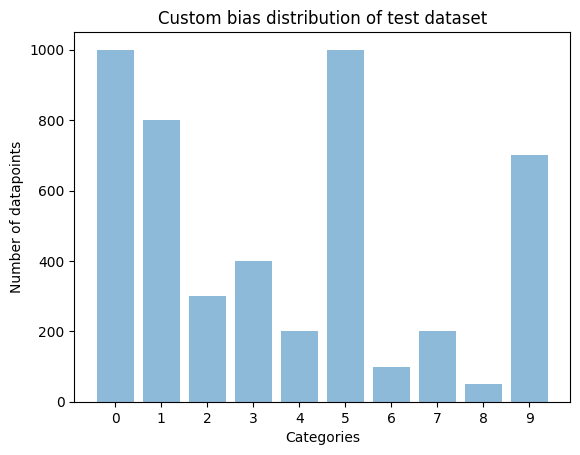

In [295]:
# Draw the bias distribution
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
y_pos = np.arange(len(objects))

plt.bar(y_pos, bias_distribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of datapoints')
plt.xlabel('Categories')

plt.title('Custom bias distribution of test dataset')

plt.show()

## Evaluate new bias test dataset

In [296]:
test_loss, test_score = model.evaluate(new_X_test, new_y_test_onehot)

print("Test Loss:", test_loss)
print("Test F1 Score:", test_score)



149/149 [==============================] - 9s 60ms/step - loss: 1.1734 - accuracy: 0.7236
Test Loss: 1.1734275817871094
Test F1 Score: 0.723578929901123


## Test calibration, single label 

In [297]:
confidences = model.predict(new_X_test)
print("First prediction:")
print(confidences[0])


First prediction:
[1.1616036e-08 4.7797094e-10 2.3708454e-07 1.1257616e-08 2.0755256e-04
 2.8227400e-05 1.2803444e-09 9.9976391e-01 3.5919549e-11 1.6525649e-09]


In [298]:
# return the highest confidence score and its corresponding label
def return_highest_confidence(predictions):
    max_confidence = 0
    label = -1
    for i in range(10):
        if predictions[i] > max_confidence:
            label = i
            max_confidence = predictions[i]
    return max_confidence, label

In [300]:
conf , label = return_highest_confidence(confidences[2001])
print(conf,label)

0.6864926 9


In [301]:
# metric driven from the predictions
confs = []
labels = []

for prediction in confidences:
    c, l = return_highest_confidence(prediction)
    confs.append(c)
    labels.append(l)

In [302]:
print(len(confs))
print(len(labels))
print(len(new_y_test))

4750
4750
4750


In [318]:
total = 0 # number of prediction with 80%+ confidence
correct_label = 0 # number of prediction with 80%+ confidence and correctly classified

print(len(labels))

for i in range(len(confs)):
    if 0 < confs[i] <= 0.4:
        total += 1
        if labels[i] == new_y_test[i]:
            correct_label += 1
            
print("Total: " + str(total))
print("Correct label: " + str(correct_label))
print("True correctness likelihood: " + str(correct_label / total))

4750
Total: 56
Correct label: 17
True correctness likelihood: 0.30357142857142855


### Test calibration with bias distribution per category

In [323]:
for category in range(10):
    print("category: " + str(category))
    category_total = 0 # number of prediction with 80%+ confidence
    category_correct_label = 0 # number of prediction with 80%+ confidence and correctly classified

    for i in range(len(confs)):
        if labels[i] != category:
            continue
        if 0.8 < confs[i] <= 1:
            category_total += 1
            if labels[i] == new_y_test[i]:
                category_correct_label += 1

    print("Total: " + str(category_total))
    print("Correct label: " + str(category_correct_label))
    print("True correctness likelihood: " + str(category_correct_label / category_total))

category: 0
Total: 778
Correct label: 724
True correctness likelihood: 0.9305912596401028
category: 1
Total: 701
Correct label: 643
True correctness likelihood: 0.9172610556348074
category: 2
Total: 197
Correct label: 134
True correctness likelihood: 0.6802030456852792
category: 3
Total: 312
Correct label: 162
True correctness likelihood: 0.5192307692307693
category: 4
Total: 146
Correct label: 96
True correctness likelihood: 0.6575342465753424
category: 5
Total: 519
Correct label: 472
True correctness likelihood: 0.9094412331406551
category: 6
Total: 136
Correct label: 71
True correctness likelihood: 0.5220588235294118
category: 7
Total: 193
Correct label: 136
True correctness likelihood: 0.7046632124352331
category: 8
Total: 89
Correct label: 35
True correctness likelihood: 0.39325842696629215
category: 9
Total: 548
Correct label: 490
True correctness likelihood: 0.8941605839416058


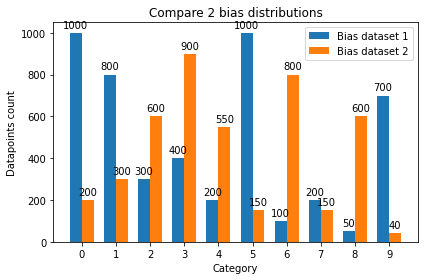

In [1]:
bias_distribution1 = [1000,800,300,400,200,1000,100,200,50,700]
bias_distribution2 = [200,300,600,900,550,150,800,150,600,40]
labels = [0,1,2,3,4,5,6,7,8,9]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bias_distribution1, width, label='Bias dataset 1')
rects2 = ax.bar(x + width/2, bias_distribution2, width, label='Bias dataset 2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Datapoints count')
ax.set_xlabel('Category')
ax.set_title('Compare 2 bias distributions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()